In [1]:
# データ分析・操作用ライブラリ
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import itertools
from collections import Counter

# NLP用ライブラリ
from wordcloud import WordCloud
import MeCab,re
from sklearn.feature_extraction.text import TfidfVectorizer

# スコア評価用ライブラリ
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support

# その他
import glob
import warnings

In [2]:
# 表示関連
# DataFrameの列数設定
pd.set_option('display.max_columns', 500)
pd.set_option("display.max_rows", 500)
warnings.filterwarnings('ignore')

In [3]:
# 形態素解析用関数
def tokenize(text,wordClassList):
    tokens = []
    tagger = MeCab.Tagger( "-Ochasen" )
    node = tagger.parseToNode(text)
    while node:
        if node.feature.split(",")[0] in wordClassList :
                replace_node = re.sub( re.compile( "[!-/:-@[-`{-~]" ), "", node.surface )
                if replace_node != "" and replace_node != " ":
                    tokens.append(replace_node)
        node = node.next
    return tokens

In [4]:
# CSVの読み込み
wikiData = pd.read_csv("csv/train.csv", encoding="utf-8")

# クラス名の取得
fileNames = glob.glob('xml/*')
classList = []
for file in fileNames:
    classList.append(file[4:])

# 読み込みデータの表示
wikiData.head()

text  target
0   ドール・フード・カンパニー  ドール・フード・カンパニー（Dole Food Compan...       1
1   南ヶ丘牧場  株式会社 南ヶ丘牧場（みなみがおかぼくじょう）は、栃木県那須高原に本拠を置く...       1
2   岩瀬牧場  岩瀬牧場（いわせぼくじょう）は、日本の福島県岩瀬郡鏡石町にある牧場である。  ...       1
3   クラギ  クラギ株式会社（くらぎ、"KURAGI Co.Ltd." ）は、三重県を中心に「...       1
4   ハッピーネモファーム  株式会社ハッピーネモファーム（""）は、北海道浦河郡浦河町にある競...       1

In [5]:
# 数字の除外
wikiData['text'] = wikiData['text'].str.replace('[0-9]+','', regex=True)

# 不要な記号の除外
path = "data/Removal Symbols.txt"
removal_symbols = []
with open(path, encoding="utf-8") as f:
    removal_symbols = [s.strip() for s in f.readlines()]
print(removal_symbols)

for symbol in removal_symbols:
    wikiData['text'] = wikiData['text'].str.replace(symbol,'')

['(', ')', '（', '）', '"', '""', '「', '」', '[', ']', '', '', '']


In [6]:
# データの表示
wikiData

text  target
0       ドール・フード・カンパニー  ドール・フード・カンパニーDole Food Company...       1
1       南ヶ丘牧場  株式会社 南ヶ丘牧場みなみがおかぼくじょうは、栃木県那須高原に本拠を置く酪農...       1
2       岩瀬牧場  岩瀬牧場いわせぼくじょうは、日本の福島県岩瀬郡鏡石町にある牧場である。  鏡石...       1
3       クラギ  クラギ株式会社くらぎ、KURAGI Co.Ltd. は、三重県を中心に農業屋など...       1
4       ハッピーネモファーム  株式会社ハッピーネモファームは、北海道浦河郡浦河町にある競走馬サラ...       1
5       宗谷黒牛  宗谷黒牛そうやくろうしは、北海道稚内市に存在する宗谷岬牧場で生産される日本最北...       1
6       花畑牧場  株式会社花畑牧場はなばたけぼくじょうとは、年平成年に設立され、北海道河西郡中札...       1
7       グローバルピッグファーム  グローバルピッグファーム英文社名：Global Pig Far...       1
8       サンライズファーム西条  株式会社サンライズファーム西条さんらいずふぁーむさいじょうは、愛...       1
9       ニチロ  株式会社ニチロNichiro Corporationは、かつて存在した水産、食品...       1
10      雪国まいたけ  株式会社雪国まいたけゆきぐにまいたけ、 は、主にマイタケを始めとするきのこ...       1
11      室崎商店  株式会社室崎商店むろさきしょうてんは、島根県江津市江津町に本社を置いていた水産...       1
12      ホクト  ホクト株式会社は、食品包装資材の製造・販売、および食用きのこを製造する企業。東証...       1
13      浜田あけぼの水産  株式会社浜田あけぼの水産はまだあけぼのすいさんは、島根県浜田市原井町に...       1
14      サカタのタネ  株式会社 サカタのタネは、神奈川県横浜市都筑区に本社を置く種苗会社である。...       1
15      京成バラ園芸  京成バラ園芸株式会社けいせいばらえんげいは、千葉県八千代市に本社を置くバラ...       1
16      カネコ種苗  カネコ種苗株式会社カネコしゅびょうは、群馬県前橋市に本社を置く種苗などの研究...       1
17      柳屋本店 水産加工  株式会社柳屋本店やなぎやほんてんは、静岡県焼津市に本社を置き、鰹節等...       1
18      きららオーガニックライフ  きららオーガニックライフは山口県美祢市美東町真名にある観光農園...       1
19      アクシーズ  株式会社アクシーズは、鹿児島県鹿児島市に本社を置くニワトリの飼育および鶏肉加...       1
20      丸六食品  丸六食品まるろくしょくひんは、日本の蒲鉾・黒はんぺん等の魚肉練り製品を製造する...       1
21      石原水産  石原水産株式会社いしはらすいさんは、静岡県焼津市中港に本社を置く水産加工品メー...       1
22      秋川牧園  株式会社秋川牧園あきかわぼくえんは、山口県山口市仁保下郷にある農業生産を主とし...       1
23      ホーブ  株式会社ホーブは、北海道上川郡東神楽町に本社を置くイチゴの苗開発や販売などを手が...       1
24      アグリ・ヴァンティアン  アグリ・ヴァンティアン株式会社は、東京に本社を置く農業総合コンサ...       1
25      サントリーフラワーズ  サントリーフラワーズ株式会社Suntoryflowers co.l...       1
26      奥多摩工業  奥多摩工業株式会社おくたまこうぎょう 英称:Okutama Kogyo CO...       2
27      関東天然瓦斯開発  関東天然瓦斯開発株式会社かんとうてんねんがすかいはつは、天然ガスの開発...       2
28      日鉄鉱業  日鉄鉱業株式会社にってつこうぎょう、英：Nittetsu Mining CO....       2
29      三井松島ホールディングス  三井松島ホールディングス株式会社みついまつしまホールディングス...       2
30      三井石油開発  三井石油開発株式会社みついせきゆかいはつは、三井グループ社によって設立され...       2
31      太平洋炭礦  太平洋炭礦株式会社たいへいようたんこうは、北海道釧路市で炭鉱を運営していた企...       2
32      ジパング 東京都  株式会社ジパングは、東京都渋谷区に本社を置く日本で唯一の金専門鉱山会社...       2
33      近江鉱業  近江鉱業株式会社 おうみこうぎょうは滋賀県米原市にある会社。愛知製鋼グループ。...       2
34      三信鉱工  三信鉱工株式会社さんしんこうこう、は、 愛知県北設楽郡東栄町に本社を置くセリサ...       2
35      日本海洋掘削  日本海洋掘削株式会社にほんかいようくっさく、は、海底石油・天然ガス田の試掘...       2
36      石炭資源開発  石炭資源開発株式会社せきたんしげんかいはつ、は、日本の電力会社の出資で設立...       2
37      帝国石油  帝国石油株式会社ていこくせきゆ、英文社名：Teikoku Oil Co. Lt...       2
38      K&Oエナジーグループ  K&Oエナジーグループ株式会社は、関東天然瓦斯開発株式会社とその...       2
39      国際石油開発  国際石油開発株式会社こくさいせきゆかいはつ、INPEX CORPORATI...       2
40      石油資源開発  石油資源開発株式会社せきゆしげんかいはつ、Japan Petroleum ...       2
41      住金鉱業  住金鉱業株式会社すみきんこうぎょうは、青森県に本社を置く企業。日鉄鉱業の子会社...       2
42      住石マテリアルズ  住石マテリアルズ株式会社すみせきマテリアルズ、英文社名：Sumisek...       2
43      共立マテリアル  共立マテリアル株式会社きょうりつマテリアル、は愛知県名古屋市港区築三町二...       2
44      矢作建設工業  矢作建設工業株式会社やはぎけんせつこうぎょう、は、愛知県名古屋市東区に本社...       3
45      進和建設工業  進和建設工業株式会社しんわけんせつこうぎょうは、大阪府堺市に本社を置く建設...       3
46      遠鉄建設  遠鉄建設えんてつけんせつは、遠鉄グループの企業の一つ。静岡県浜松市を中心に、建...       3
47      北陸電気工事  北陸電気工事株式会社ほくりくでんきこうじは、富山県富山市に本社を置く北陸電...       3
48      藤田エンジニアリング  藤田エンジニアリング株式会社ふじたエンジニアリングは、群馬県高崎市...       3
49      井上工業  井上工業株式会社いのうえこうぎょうは、群馬県高崎市に本社を置いていた建設会社。...       3
50      菊池建設 東京都  菊池建設株式会社きくちけんせつ、英称：Kikuchi Construc...       3
51      四電工  株式会社四電工よんでんこうは、香川県高松市に本社を置く四国電力グループの電気設備...       3
52      北海電気工事  北海電気工事株式会社ほっかいでんきこうじ略称　北海電工は、北海道札幌市白石...       3
53      熊谷組  株式会社熊谷組くまがいぐみは、日本の建設会社である。本社は東京都新宿区に置くが、...       3
54      コムシスエンジニアリング  コムシスエンジニアリング株式会社は主として通信の工事を請け負う...       3
55      TOSYS  株式会社TOSYSトーシスは、コムシスホールディングスの子会社で、長野県長野...       3
56      TSUCHIYA  TSUCHIYA株式会社つちや、TSUCHIYA CORPORATIO...       3
57      土屋ツーバイホーム  株式会社土屋ツーバイホームつちやツーバイホームは、かつて北海道札幌市...       3
58      新日本建設  新日本建設株式会社しんにほんけんせつは、千葉県千葉市美浜区に本社を置く建設会...       3
59      南海辰村建設  南海辰村建設株式会社なんかいたつむらけんせつ、は、大阪府大阪市浪速区に本社...       3
60      百年住宅中部  百年住宅中部株式会社ひゃくねんじゅうたくちゅうぶは、愛知県名古屋市に本社の...       3
61      サンヨーホームズ  サンヨー

# データ数の確認

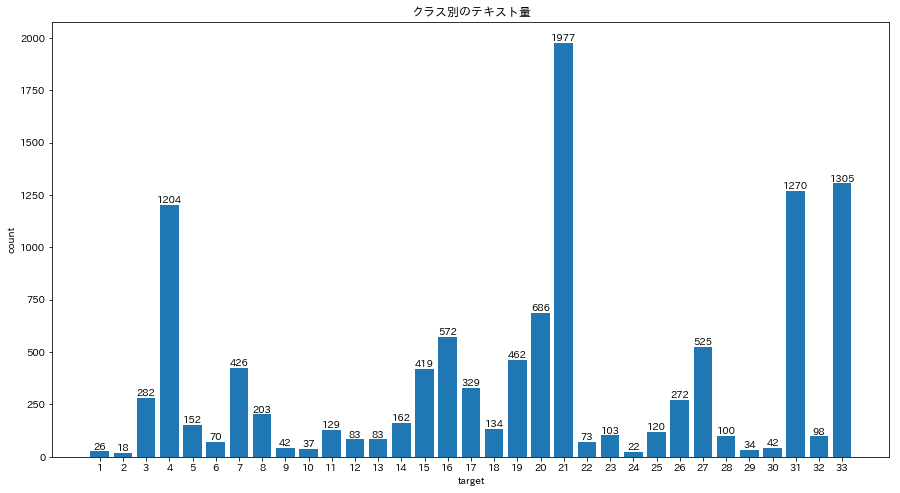

In [7]:
# クラス別のテキスト量を確認
wiki_gpby = wikiData.groupby('target').count()
y = wiki_gpby['text'].values
x =wiki_gpby.index.values

plt.figure(figsize=(15, 8))
plt.title("クラス別のテキスト量")
plt.xlabel("target")   
plt.ylabel("count")
plt.xticks(x)
plt.bar(x, y)

# 棒グラフ内に数値を書く
for t, c in zip(x, y):
    plt.text(t, c, c, ha='center', va='bottom')
    
plt.show()

・サンプル数にばらつきがある。最も少ないクラスは18個しか存在せず、学習するのに十分な数があるとは言えない

・不均衡データである為ダウンサンプリングも選択肢の一つだが、数が著しく少ないクラスが多く、学習データが少なくなりすぎそう

# WordCloud

In [8]:
# ストップワードの読み込み
path = "data/Slothlib.txt"
stopWords = []
with open(path, encoding="utf-8") as f:
    stopWords = [s.strip() for s in f.readlines()]

In [9]:
# 全テキストの結合
allText = ''
for text in wikiData['text'].values:
    allText += ''.join(text)

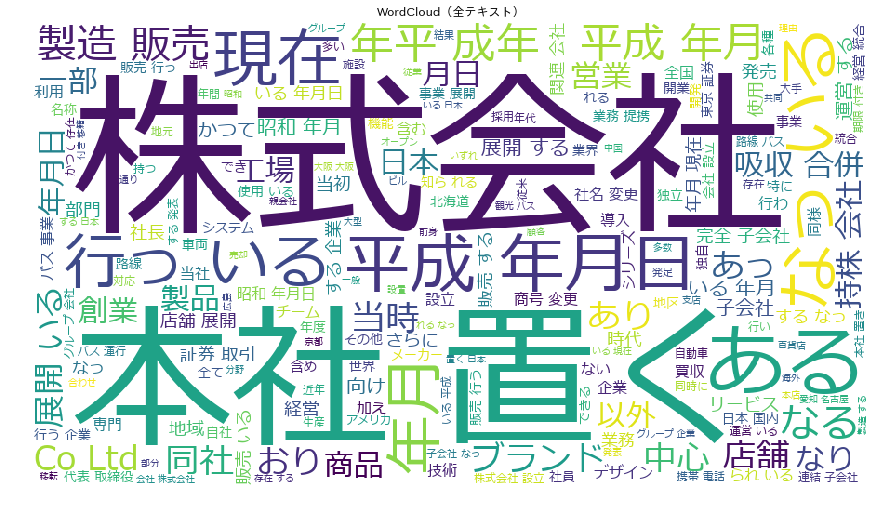

In [10]:
# 形態素解析
wordClassList = ['形容詞', '動詞','名詞', '副詞']
words = tokenize(allText,wordClassList)
words_joined = ' '.join(words)

# WordCloud
fpath = 'C:\Windows\Fonts\Meiryo UI\meiryo.ttc'
wordcloud = WordCloud(background_color="white", font_path=fpath, width=900, height=500, stopwords=set(stopWords)).generate(words_joined)

plt.figure(figsize=(15,12))

plt.title("WordCloud（全テキスト）")
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [11]:
# 単語別の出現回数を確認
counter = Counter(words)
wordCount = pd.DataFrame(counter.most_common(),columns = ['word','count'])
wordCount

word  count
0                              し  91874
1                              年  40080
2                             いる  38435
3                              さ  31111
4                              れ  30765
5                             する  30133
6                           株式会社  23151
7                              い  19462
8                             年月  18017
9                              市  16684
10                            事業  15861
11                             県  15821
12                           年月日  15533
13                            こと  14687
14                            会社  14423
15                            なっ  13768
16                            販売  12090
17                             店  11749
18                            店舗  11498
19                            本社  10966
20                            日本  10857
21                            企業   9937
22                            製造   8702
23                            東京   8548
24                            ある   8498
25                            現在   7962
26                            バス   7768
27                          グループ   7764
28                            ため   7430
29                             者   7117
30                            設立   7065
31                            れる   6987
32                            平成   6960
33                             区   6662
34                            開発   6529
35                             化   6405
36                            行っ   6095
37                             円   6006
38                            置く   5978
39                            展開   5959
40                             的   5837
41                           子会社   5708
42                            放送   5626
43                            昭和   5610
44                            営業   5401
45                          メーカー   5398
46                             後   5321
47                             社   5302
48                            おり   5278
49                            運営   5237
50                            経営   5182
51                             所   5046
52                             用   4912
53                            なる   4719
54                            大阪   4602
55                            変更   4525
56                            開始   4508
57                            製品   4502
58                             駅   4499
59                            創業   4437
60                            商品   4349
61                          ブランド   4338
62                            中心   4316
63                             等   4306
64                            同社   4134
65                          サービス   4057
66                            社名   3968
67                             都   3876
68                             町   3823
69                            路線   3798
70                            もの   3764
71                            合併   3753
72                            使用   3740
73                            工場   3707
74                            行う   3604
75                            向け   3593
76                             億   3542
77                             中   3536
78                            よう   3493
79                             名   3490
80                            業務   3458
81                            これ   3439
82                            られ   3437
83                           その後   3264
84                            一部   3231
85                            なり   3203
86                            運行   3163
87                            社長   3148
88                             線   3144
89                             人   3109
90                             の   3101
91                            関連   3035
92                             一   3031
93                             部   3020
94                            当時   3017
95                             機   3013
96                            成年   2999
97                            あっ   2997
98                            機器   2982
99                          

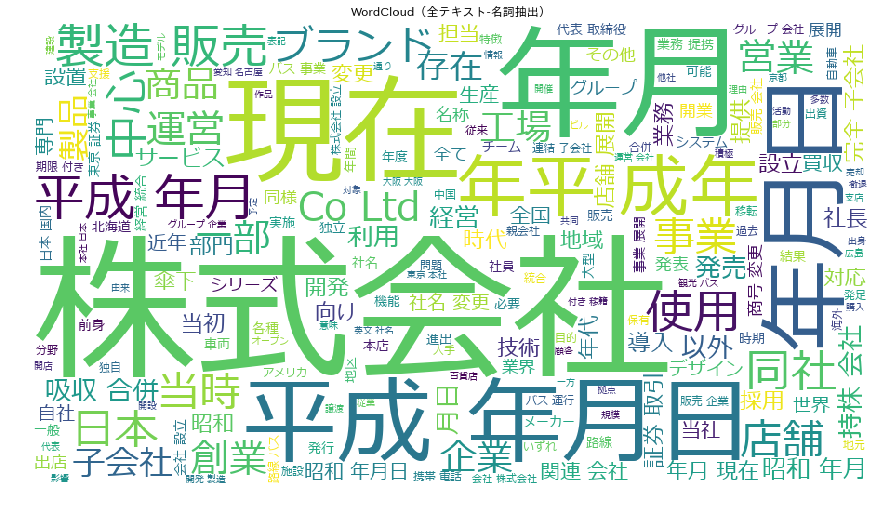

In [12]:
# 名詞のみ抽出
wordClassList = ['名詞']
words = tokenize(allText,wordClassList)
noun_joined = ' '.join(words)

# WordCloud
wordcloud = WordCloud(background_color="white", font_path=fpath, width=900, height=500, stopwords=set(stopWords)).generate(noun_joined)

plt.figure(figsize=(15,12))
plt.title("WordCloud（全テキスト-名詞抽出）")
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

・'株式会社'、'同社'、'CO Ltd'など、どの業種でも出てくる単語や'平成'、'昭和'、'同年'、'当時'などの時を示す単語が多い。削除候補。

・'製造'、'販売'などの単語を名詞として抜けるようなので、動詞はいらなそう

In [13]:
# 単語別の出現回数を確認
counter = Counter(words)
wordCount = pd.DataFrame(counter.most_common(),columns = ['word','count'])
wordCount

word  count
0                              年  40080
1                           株式会社  23151
2                             年月  18017
3                              市  16684
4                             事業  15861
5                              県  15821
6                            年月日  15533
7                             こと  14687
8                             会社  14423
9                             販売  12090
10                             店  11749
11                            店舗  11498
12                            本社  10966
13                            日本  10857
14                            企業   9937
15                            製造   8702
16                            東京   8548
17                            現在   7962
18                            バス   7768
19                          グループ   7764
20                            ため   7426
21                             者   7117
22                            設立   7065
23                            平成   6960
24                             区   6662
25                            開発   6529
26                             化   6405
27                             円   5963
28                            展開   5959
29                             的   5837
30                           子会社   5708
31                            放送   5626
32                            昭和   5610
33                            営業   5401
34                          メーカー   5398
35                             後   5321
36                             社   5302
37                            運営   5237
38                            経営   5182
39                             所   5046
40                             用   4912
41                            大阪   4602
42                            変更   4525
43                            開始   4508
44                            製品   4502
45                             駅   4499
46                            創業   4437
47                            商品   4349
48                          ブランド   4338
49                            中心   4316
50                             等   4306
51                            同社   4134
52                          サービス   4057
53                            社名   3968
54                             都   3876
55                             町   3823
56                            路線   3798
57                            もの   3764
58                            合併   3753
59                            使用   3740
60                            工場   3707
61                             億   3542
62                             中   3536
63                             名   3490
64                            よう   3489
65                            業務   3458
66                            これ   3439
67                           その後   3264
68                            一部   3231
69                            向け   3187
70                            運行   3163
71                            社長   3148
72                             線   3144
73                             人   3109
74                             の   3101
75                            関連   3035
76                             一   3031
77                             部   3020
78                            当時   3017
79                             機   3013
80                            成年   2999
81                            機器   2982
82                             万   2968
83                            生産   2956
84                            年平   2955
85                             車   2951
86                             主   2891
87                            番組   2884
88                             時   2876
89                            発表   2861
90                            株式   2785
91                             位   2768
92                            ほか   2757
93                            月日   2743
94                            利用   2722
95                             日   2705
96                           自動車   2699
97                             内   2669
98                            食品   2649
99                          

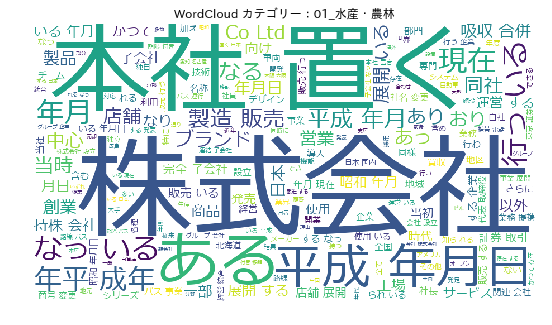

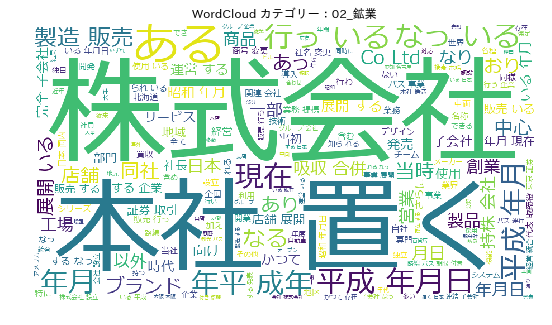

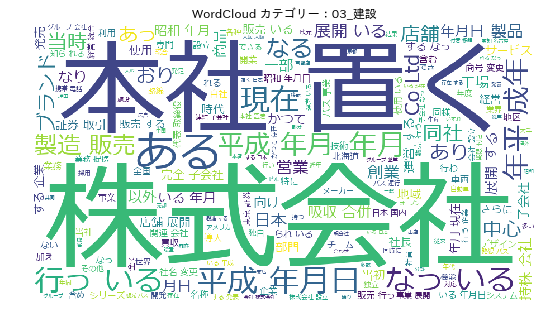

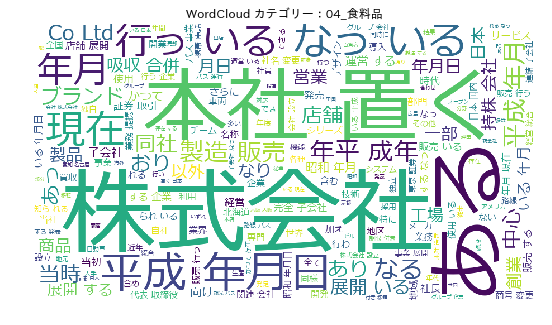

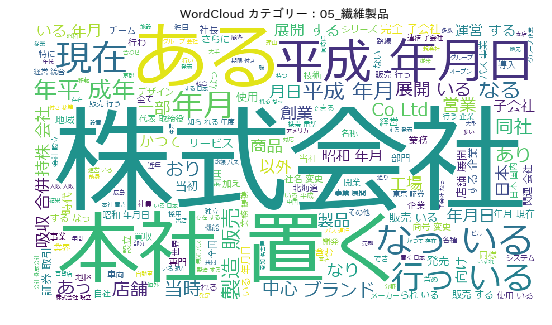

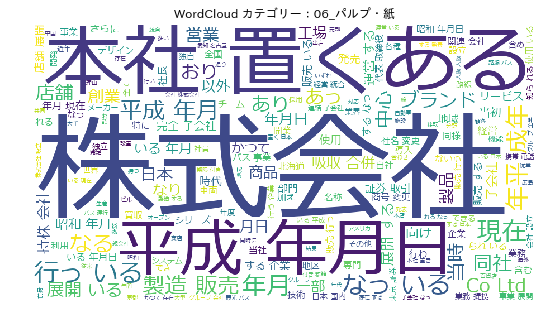

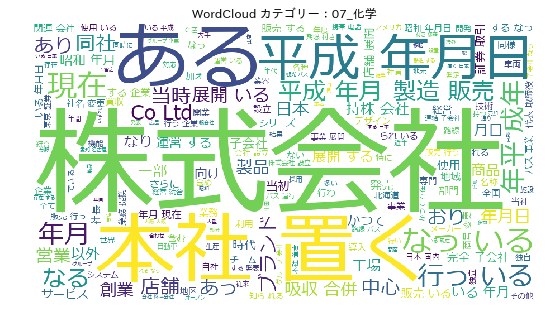

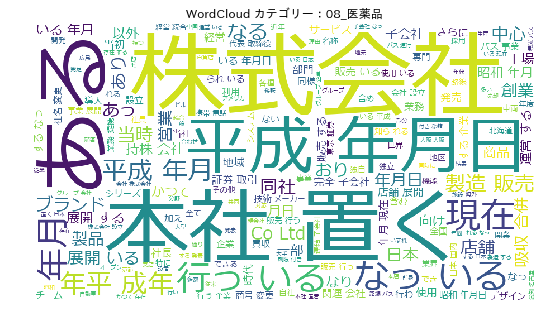

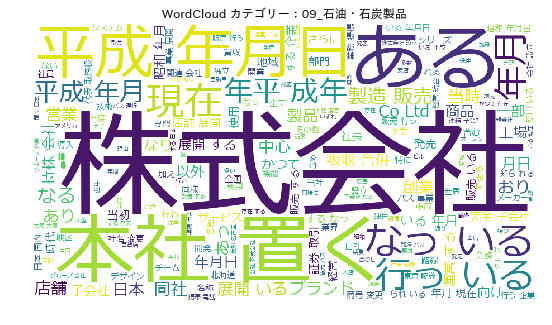

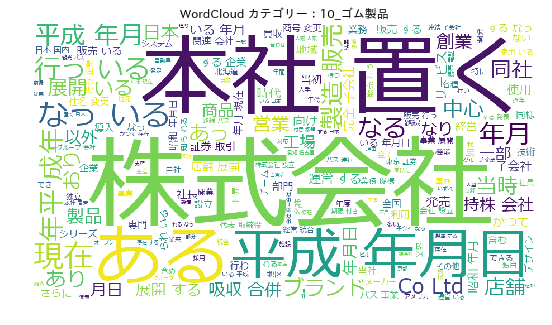

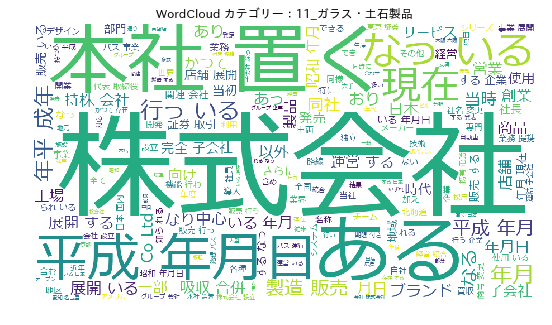

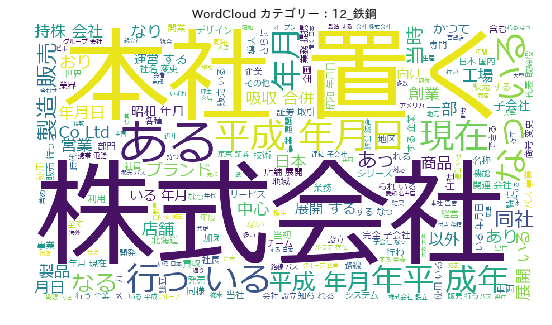

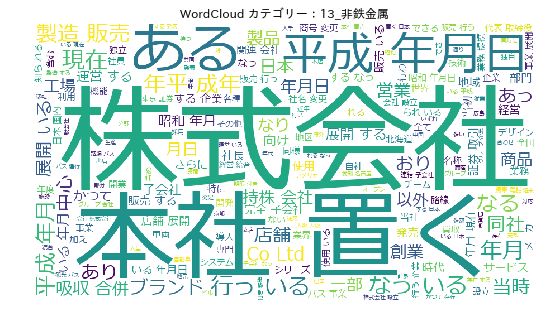

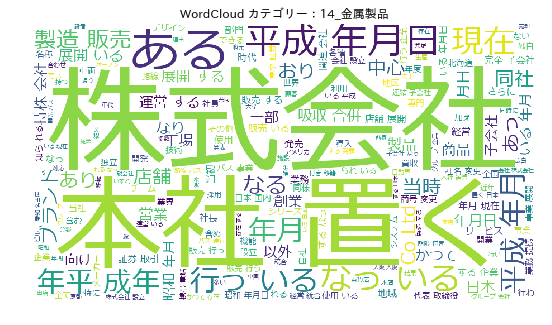

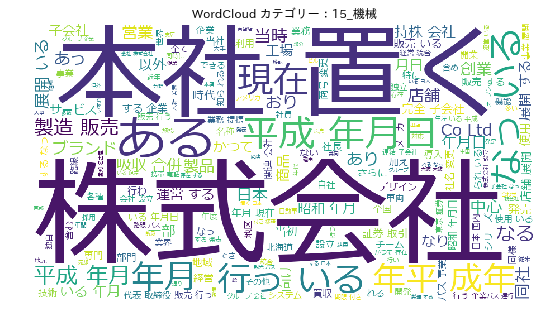

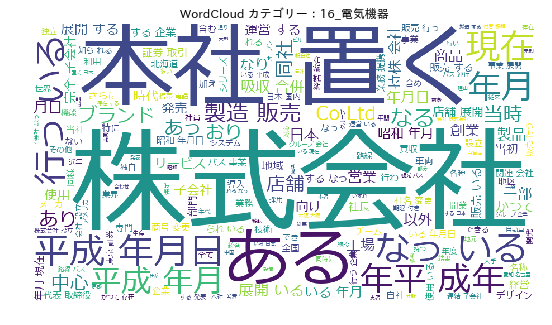

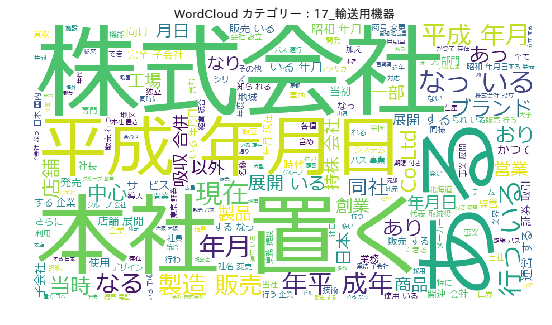

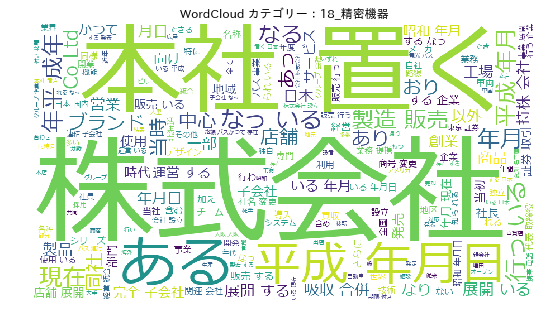

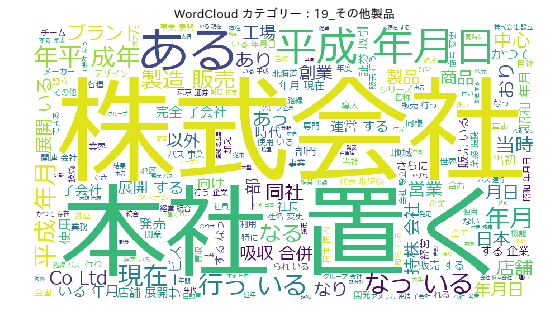

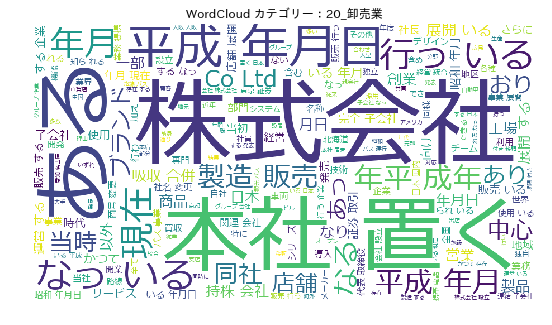

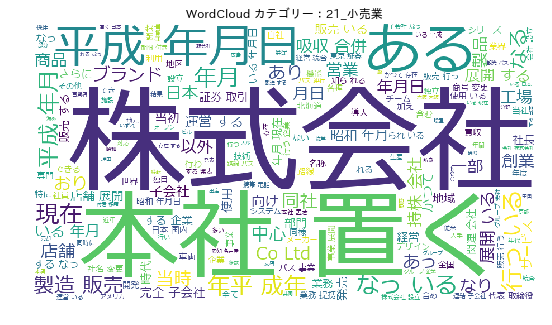

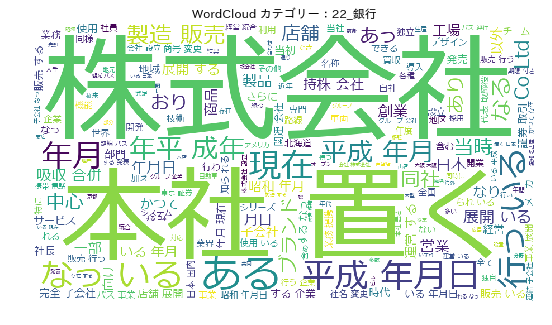

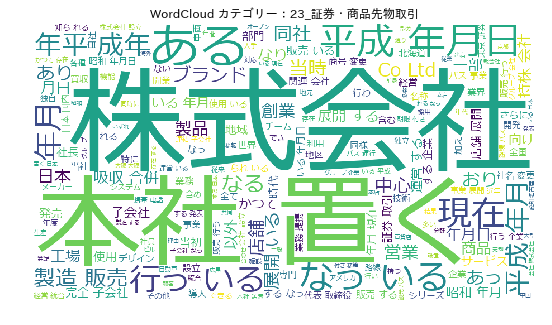

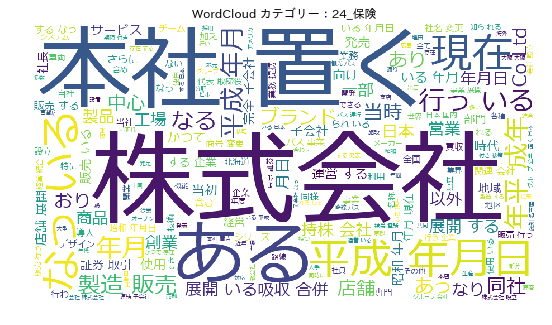

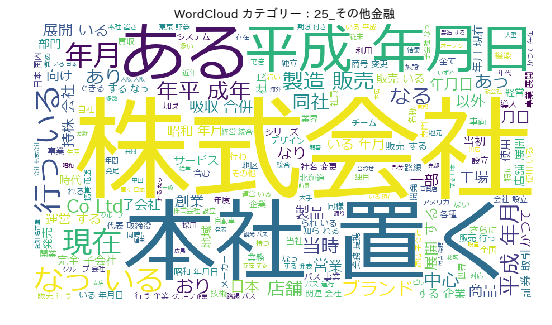

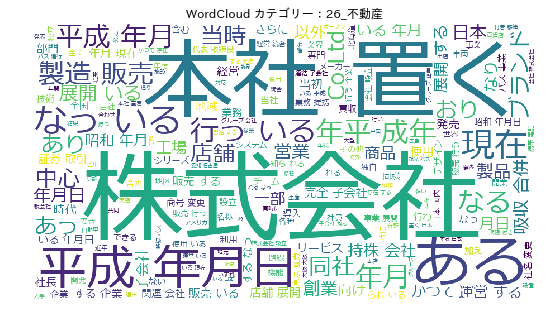

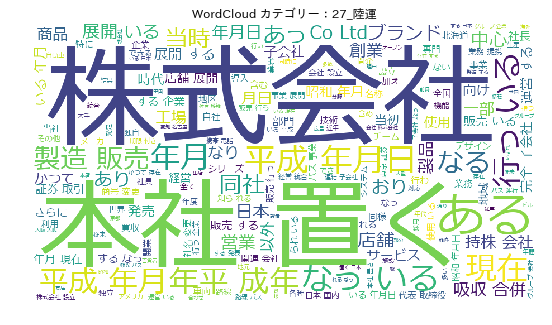

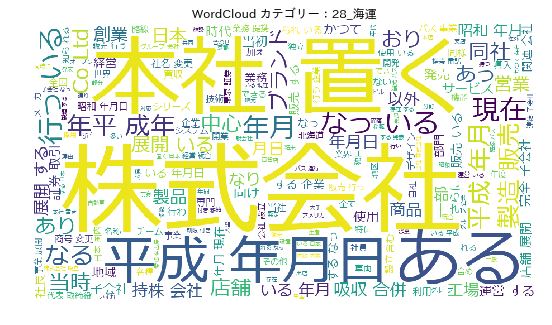

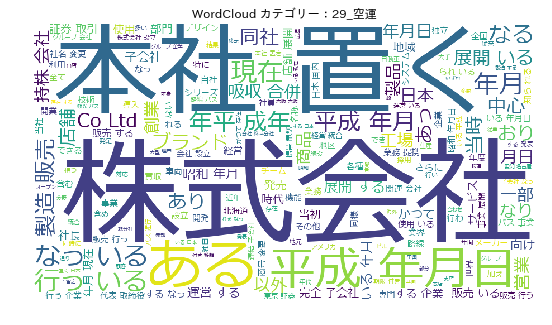

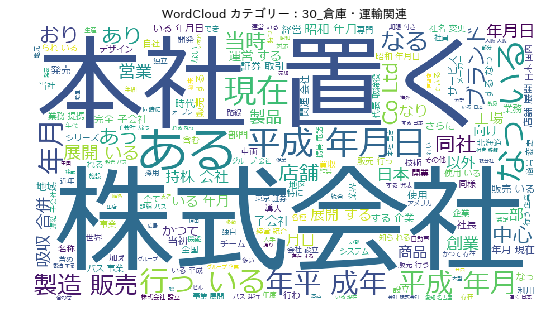

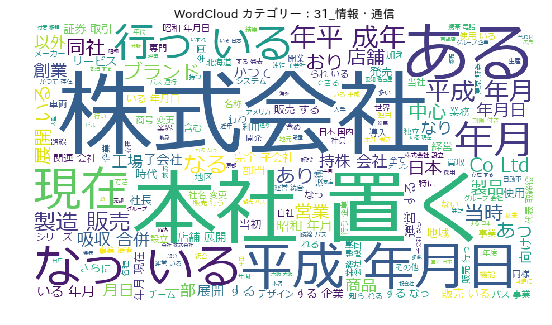

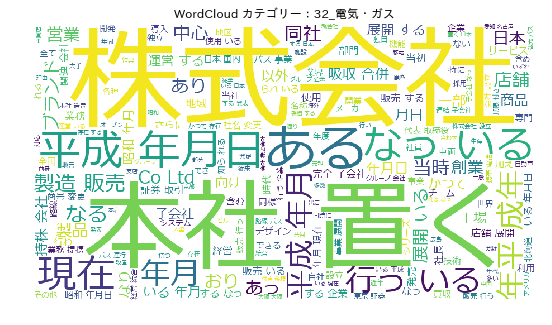

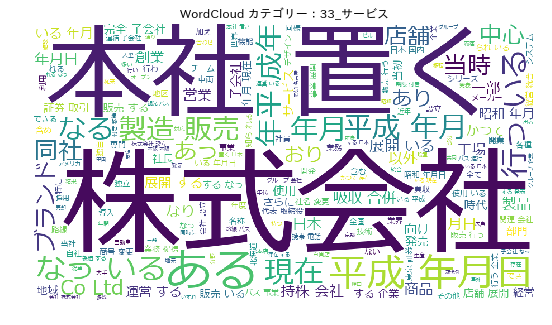

In [14]:
# カテゴリー別に表示
targetText = ''
for i in range(1,34):
    targetData = wikiData[wikiData['target'] == i]
    
    for text in targetData['text'].values:
        targetText += "".join(text)
    
    # 形態素解析
    wordClassList = ['形容詞', '動詞','名詞', '副詞']
    words = tokenize(allText,wordClassList)
    words_joined = ' '.join(words)
    
    # WordCloud
    wordcloud = WordCloud(background_color="white", font_path=fpath, width=900, height=500, stopwords=set(stopWords)).generate(words_joined)

    plt.figure(figsize=(9,6))
    plt.title("WordCloud カテゴリー：" + classList[i-1])
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
    targetText = ''


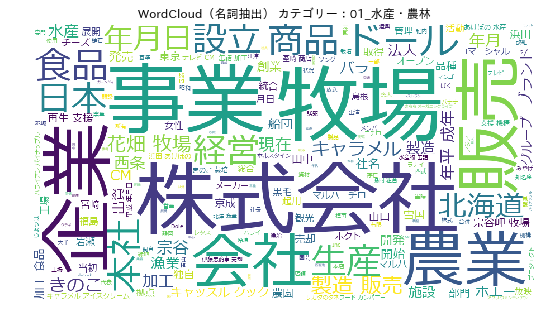

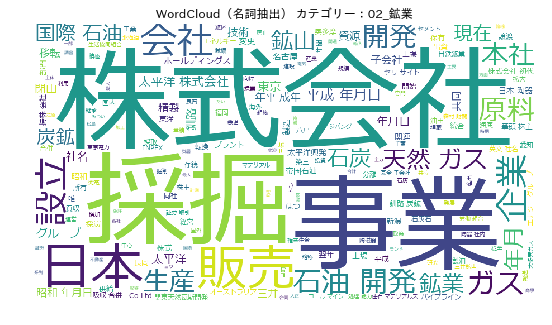

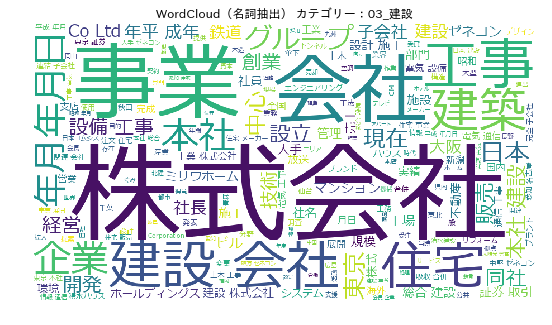

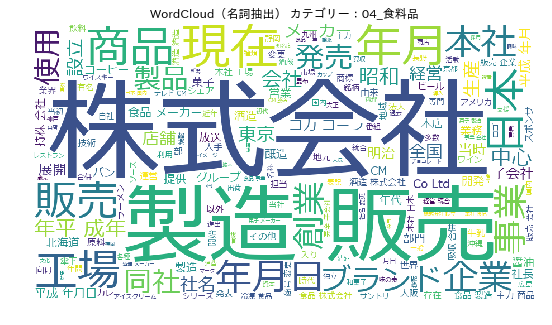

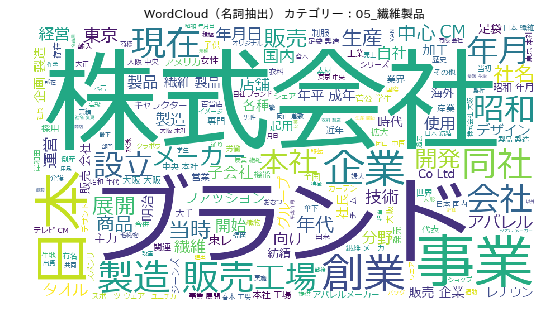

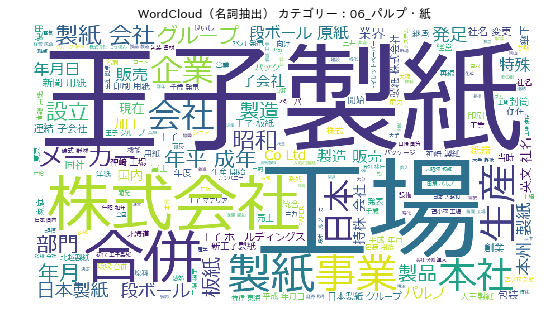

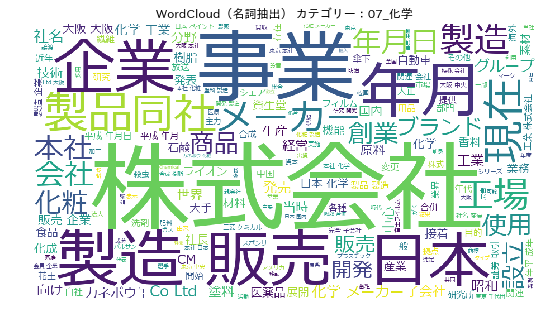

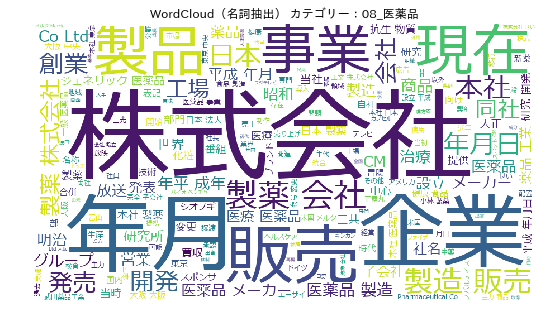

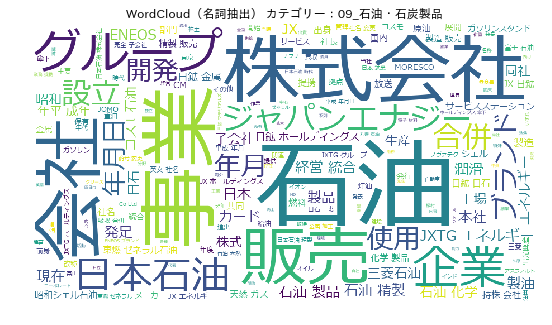

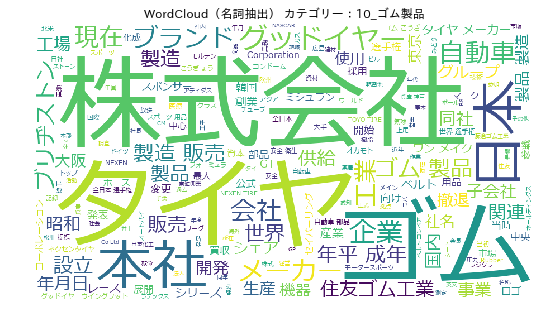

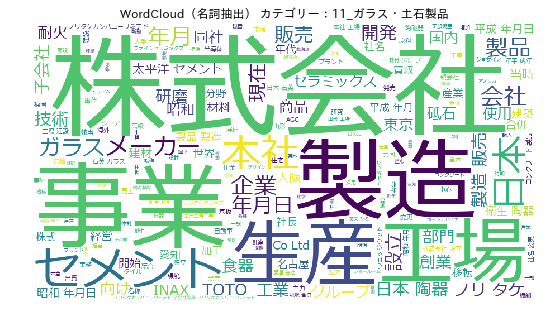

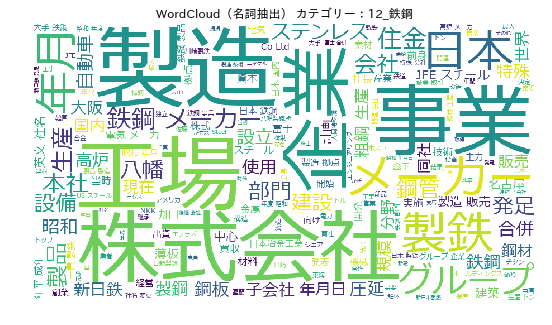

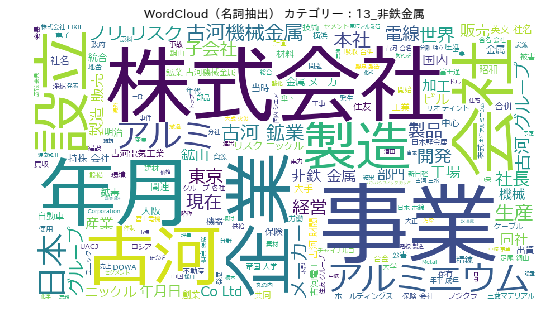

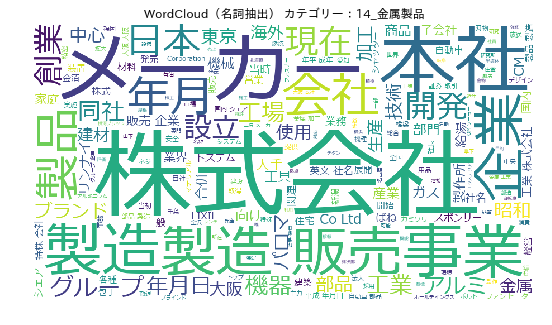

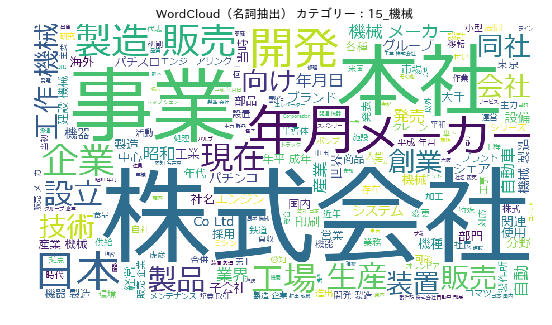

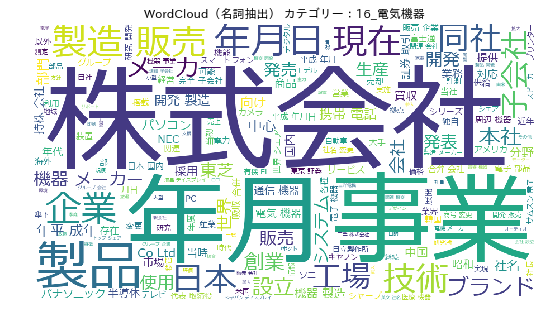

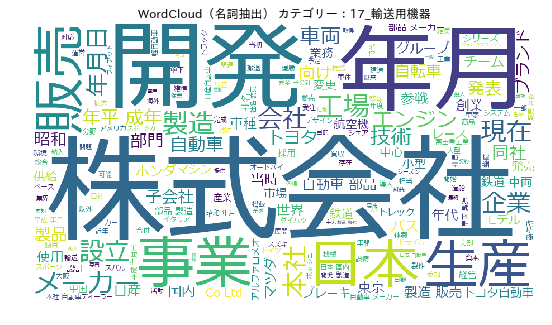

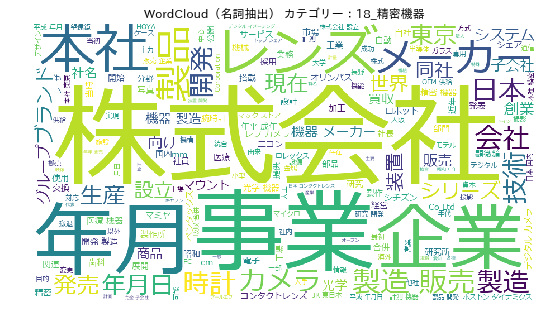

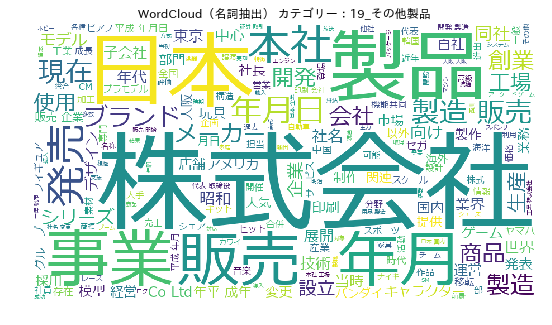

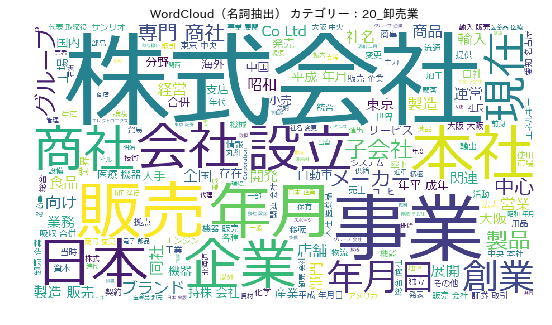

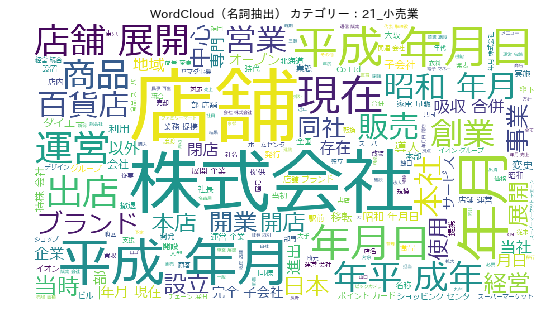

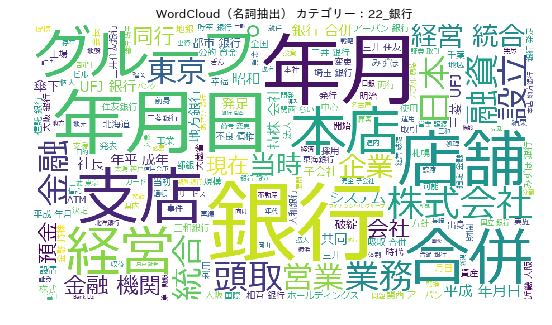

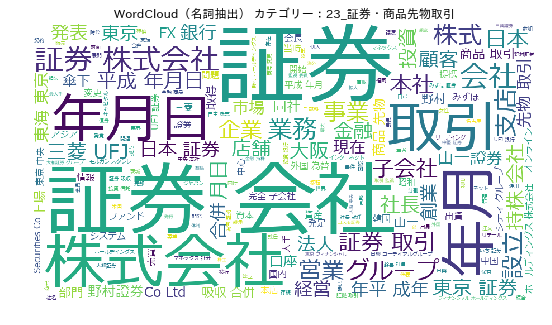

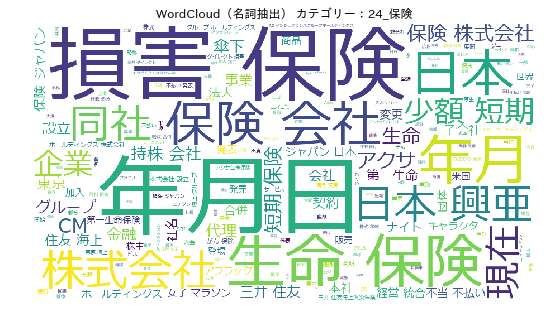

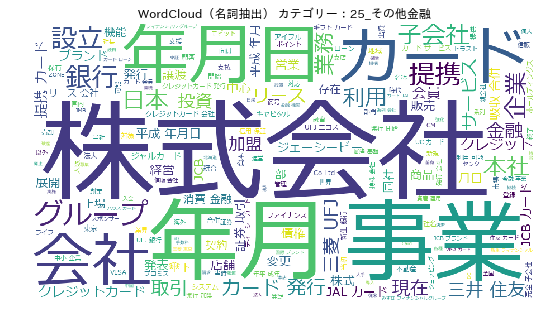

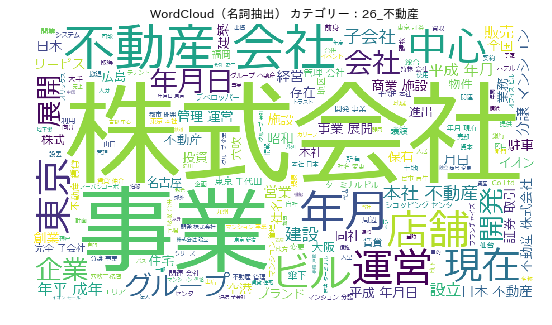

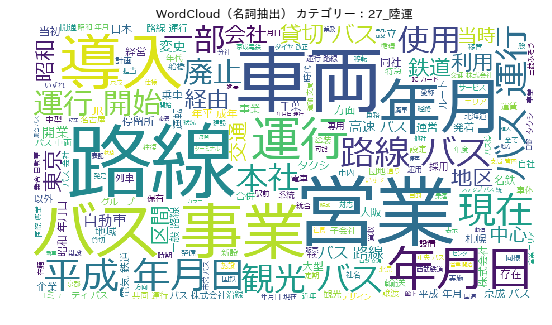

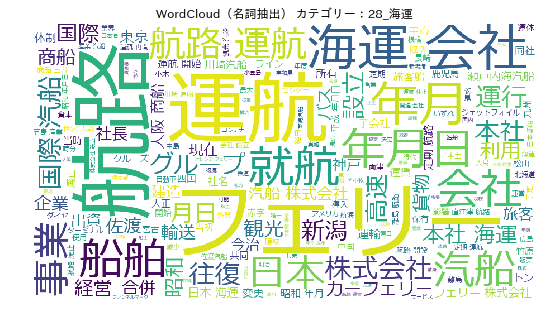

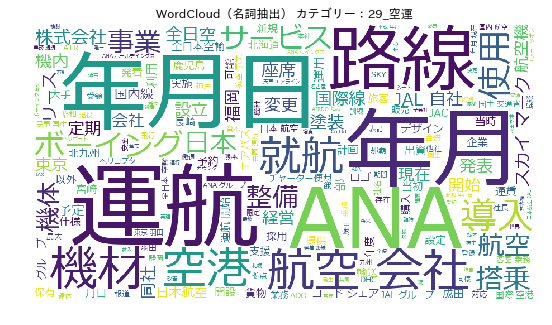

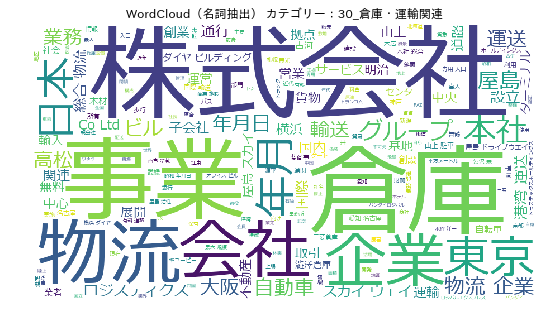

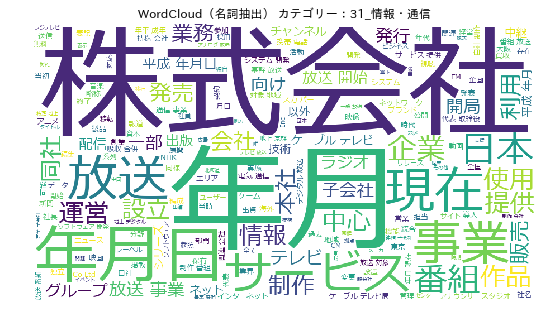

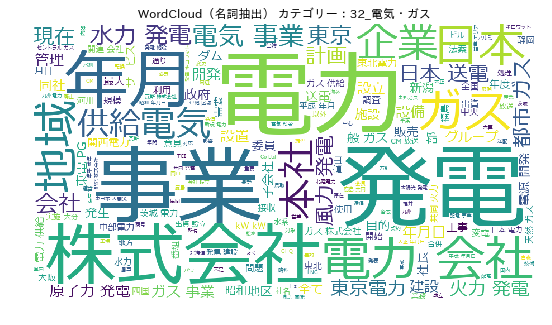

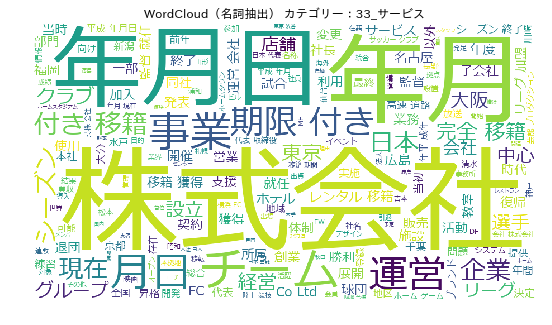

In [15]:
# カテゴリー別に表示
targetText = ' '
for i in range(1,34):
    targetData = wikiData[wikiData['target'] == i]
    for text in targetData['text'].values:
        targetText += ''.join(text)
    
    # 名詞のみ抽出
    wordClassList = ['名詞']
    targetWords = tokenize(targetText,wordClassList)
    noun_joined = ' '.join(targetWords)
    
    # WordCloud
    wordcloud = WordCloud(background_color="white", font_path=fpath, width=900, height=500, stopwords=set(stopWords)).generate(noun_joined)

    plt.figure(figsize=(9,6))
    plt.title("WordCloud（名詞抽出） カテゴリー：" + classList[i-1])
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
    targetText = ''

### 試しにLight GBMでスコアを出してみる

In [16]:
# Numpy配列へ変換
X_text = wikiData.text.values
y_target = wikiData.target.values

In [17]:
# トレーニングデータ、テストデータの分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_text , y_target, test_size=0.2, random_state=42, stratify=y_target)

In [18]:
# TfidfVectorizerで使うtokenizer
def Tfidf_tokenize(text):
    tokens = []
    tagger = MeCab.Tagger( "-Ochasen" )
    node = tagger.parseToNode(text)
    while node:
        if node.feature.split(",")[0] in ['形容詞', '動詞','名詞', '副詞'] :
                replace_node = re.sub( re.compile( "[!-/:-@[-`{-~]" ), "", node.surface )
                if replace_node != "" and replace_node != " ":
                    tokens.append(replace_node)
        node = node.next
    return tokens

In [19]:
# TF-IDFへ変換
vectorizer = TfidfVectorizer(tokenizer=Tfidf_tokenize)
vectorizer.fit(X_text)
train_matrix = vectorizer.transform(X_train)
test_matrix = vectorizer.transform(X_test)

In [20]:
# Light GBM
import lightgbm as lgb

clf = lgb.LGBMClassifier(objective='multiclass', num_class=33)
clf.fit(train_matrix, y_train)
cv_scores = cross_val_score(clf, train_matrix, y_train, cv=5)

print("Training score：" + str(clf.score(train_matrix, y_train)))
print("Cross-Validation score：" + str(np.mean(cv_scores)))
print("Test score：" + str(clf.score(test_matrix, y_test)))

Training score：0.999672774869
Cross-Validation score：0.745002414406
Test score：0.746945898778


In [21]:
# テストスコアのクラス別適合率、再現率、F1値を計算
pred_test = clf.predict(test_matrix)
p_r_f = precision_recall_fscore_support(y_test, pred_test)

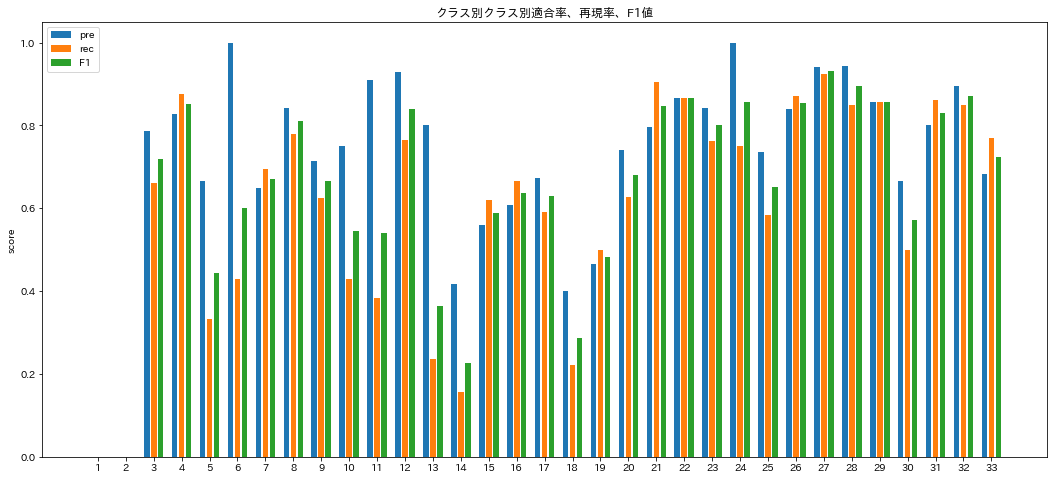

In [22]:
# クラス別適合率、再現率、F1値を表示
plt.figure(figsize=(18, 8))
plt.title("クラス別クラス別適合率、再現率、F1値")
plt.ylabel("score")
plt.xticks(x)
plt.bar(x-0.25, p_r_f[0], width=0.2, label='pre')
plt.bar(x, p_r_f[1], width=0.2, label='rec')
plt.bar(x+0.25, p_r_f[2], width=0.2, label='F1')
plt.legend(loc=2)    
plt.show()

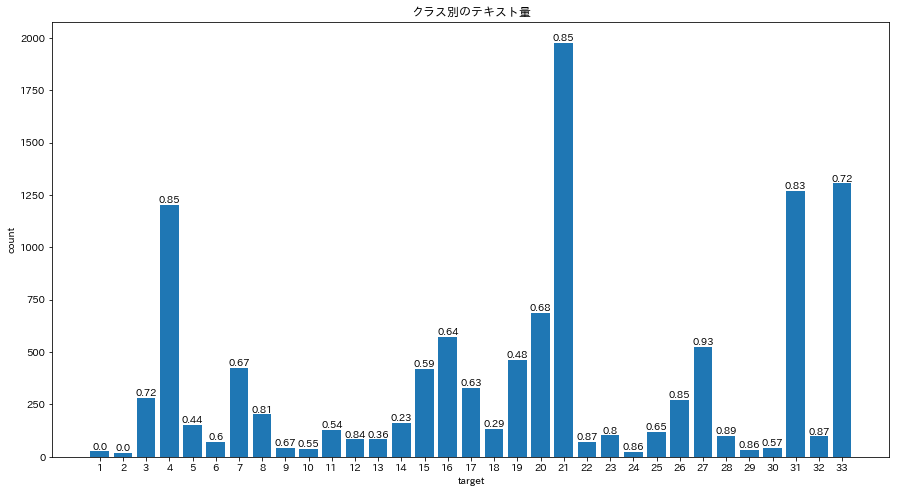

In [23]:
# テキスト量へF1値を書き込んでみる
plt.figure(figsize=(15, 8))
plt.title("クラス別のテキスト量")
plt.xlabel("target")   
plt.ylabel("count")
plt.xticks(x)
plt.bar(x, y)

# 棒グラフ内にF1値を書く
for t, c, f in zip(x, y, p_r_f[2]):
    plt.text(t, c, round(f,2), ha='center', va='bottom')
    
plt.show()

テキスト量の少ないクラスはF1値が軒並み低いかと思われたが、僅かなデータ量でも銀行や保険、海運のようなクラスはスコアが良い。悪いクラスとの差異は何なのか考える。